# MRS_Voxel-to-Voxel

Prefixes:
=========
-) BETA_ nii the BETA files contain the Fisher transformed coefficients ( z=atanh(r) ). When the Analyses.measure is set to 3 (regression) or 4 (multivariate regression), then the BETA files contain the regression coefficients (beta values) and the corr files should be disregarded (they actually contain tanh(beta) but these are not particularly meaningful measures). 

-) corr_ nii When the Analyses.measure field is set to 1 (bivariate correlation) or 2 (semi-partial correlation) the corr fles contain the correlation coefficients (r) (or semi-partial correlation coefficients when Analyses.measure is set to 2)..... corr_* files are only generated if you select the corresponding option in the Setup->Options tab ('Create first-level seed-to-voxel r-maps').

-) p_corr nii the p_corr and pFDR images simply contain the uncorrected and FDR-corrected p-values, respectively

-) pFDR nii the p_corr and pFDR images simply contain the uncorrected and FDR-corrected p-values, respectively

-) resultsROI mat

-) se nii
-) 

## Sources

In [1]:
import glob
import nibabel as nib
import pandas as pd
import seaborn as sns
from nilearn import plotting
import numpy as np
from scipy.io import loadmat
from scipy import stats
import multiprocess as mp

In [2]:
mat = loadmat('/media/veracrypt1/NeuroMet_fmri/MRS_Voxel/_list_sources.mat')

In [3]:
mat['sourcenames']

array([[array(['DMN_alldiag_LRPCC_gmmasked'], dtype='<U26'),
        array(['DMN_anatomical_gmmasked'], dtype='<U23'),
        array(['DMN_alldiag_targets_gmmasked.cluster001'], dtype='<U39'),
        array(['DMN_alldiag_targets_gmmasked.cluster002'], dtype='<U39'),
        array(['DMN_alldiag_targets_gmmasked.cluster003'], dtype='<U39'),
        array(['MRS_Voxel'], dtype='<U9')]], dtype=object)

In [4]:
# MRS Voxel is source 6

In [5]:
# Grab all MRS-Voxel-to-whole-Brain connectivity maps niftis
s1_beta_path = glob.glob('/media/veracrypt1/NeuroMet_fmri/MRS_Voxel/BETA_Subject0*_Condition001_Source006.nii')
len(s1_beta_path)

72

In [6]:
example_img = nib.load(s1_beta_path[0])

In [7]:
subnumber = len(s1_beta_path)

In [8]:
# sort them
s1_beta_path = sorted(s1_beta_path, key=(lambda x: x.split('_')[-3][-3:]))

In [9]:
# Load Subjects' data

In [10]:
cov_path = '/home/orco/Dokumente/Charitè/fmri/conn_covs_jun_SCD.csv'
data = pd.read_csv(cov_path)

In [11]:
data.head()

,Unnamed: 0,Conn_Nr,NeuroMet_Nr,Age_All,VLMT_Dg7,NeuroMET_MS,Diagnosis,diag2,GSH_All,CRLB,pcc2dmn,pcc2dmn_gm,pcc2gm,pcc2c1,pcc2c2,pcc2c3,pcc2c1_gm,pcc2c2_gm,pcc2c3_gm
0,0,1,3,79,6,0.54,1,2,1094,8,0.762273,0.756705,0.257774,0.184026,0.848625,0.344404,0.198947,0.649464,0.565006
1,1,2,4,72,14,1.02,0,0,934,12,0.931346,0.860219,0.282091,0.522359,1.085046,0.614115,0.418012,1.038114,0.550157
2,2,3,6,74,11,1.74,0,0,1238,10,0.548219,0.590011,0.329610,0.266047,0.805199,0.119476,0.230188,0.756401,0.184789
3,3,4,7,69,8,1.02,-1,1,941,13,1.093036,1.128538,0.602832,0.347373,1.087209,0.979453,0.274833,1.031719,1.039667
4,4,5,8,68,14,1.53,0,0,1576,8,1.283464,1.264611,0.486241,0.680216,1.074172,0.913704,0.859424,0.958173,0.941854


### thresholding to 0.3 every image (corresponding p ~ 0.01)

In [15]:
%%time
def threshold_conn_map(conn_map, threshold = 0.3, subnum = 0):
    return (subnum, np.where(conn_map>threshold,conn_map,0))

threshold = 0.3
conns_thrs = list(range(subnumber)) # initialize conn list

p = mp.Pool(processes = 4)
for n in range(subnumber):
    conn_map = nib.load(s1_beta_path[n]).get_fdata()
    res = p.apply_async(threshold_conn_map, (conn_map, threshold, n)).get()
    conns_thrs[res[0]] = res[1]
    print('{}: done'.format(res[0]))

0: done
1: done
2: done
3: done
4: done
5: done
6: done
7: done
8: done
9: done
10: done
11: done
12: done
13: done
14: done
15: done
16: done
17: done
18: done
19: done
20: done
21: done
22: done
23: done
24: done
25: done
26: done
27: done
28: done
29: done
30: done
31: done
32: done
33: done
34: done
35: done
36: done
37: done
38: done
39: done
40: done
41: done
42: done
43: done
44: done
45: done
46: done
47: done
48: done
49: done
50: done
51: done
52: done
53: done
54: done
55: done
56: done
57: done
58: done
59: done
60: done
61: done
62: done
63: done
64: done
65: done
66: done
67: done
68: done
69: done
70: done
71: done
CPU times: user 11.8 s, sys: 29.6 s, total: 41.5 s
Wall time: 2min 13s


In [21]:
conns_thrs[0].shape

(181, 217, 181)

CPU times: user 3 s, sys: 352 ms, total: 3.35 s
Wall time: 3.24 s


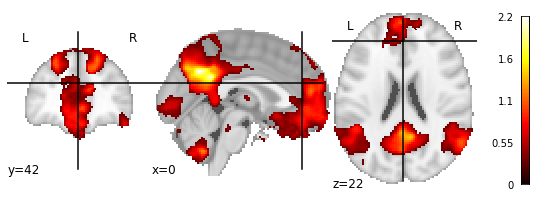

In [24]:
%%time
# Plot a thresholded conn_map
i = conns_thrs[12]
plotting.plot_stat_map(nib.Nifti1Image(i, example_img.affine, header=example_img.header), cut_coords=(0,42,22))

In [25]:
%%time    
def avg_conn(conns_thrs, subnum):
    return (subnum, conns_thrs.sum()/conns_thrs.astype(bool).sum())

avg_conns = list(range(subnumber)) # initialize conn list

p = mp.Pool(processes = 4)
for subnum in range(subnumber):
    res = p.apply_async(avg_conn,(conns_thrs[subnum], subnum)).get()
    avg_conns[res[0]] = res[1]

CPU times: user 4.09 s, sys: 7.79 s, total: 11.9 s
Wall time: 32.4 s


In [26]:
data['mrs_to_voxel_thr03_masked'] = avg_conns

<AxesSubplot:xlabel='diag2', ylabel='mrs_to_voxel_thr03_masked'>

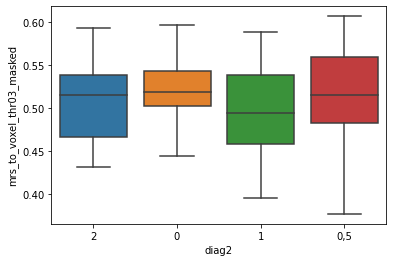

In [52]:
sns.boxplot(x='diag2', y='mrs_to_voxel_thr03_masked', data=data)

In [53]:
stats.f_oneway(data[(data.diag2=='0')].mrs_to_voxel_thr03_masked.values,
              data[(data.diag2=='0,5')].mrs_to_voxel_thr03_masked.values,
              data[(data.diag2=='1')].mrs_to_voxel_thr03_masked.values,
              data[(data.diag2=='2')].mrs_to_voxel_thr03_masked.values)

F_onewayResult(statistic=1.0381466887290531, pvalue=0.3813503711465609)

<AxesSubplot:xlabel='GSH_All', ylabel='mrs_to_voxel_thr03_masked'>

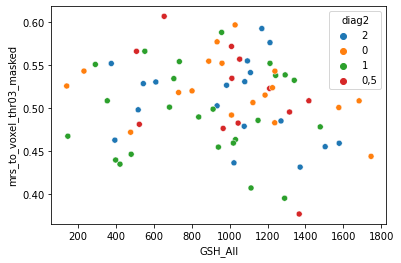

In [31]:
sns.scatterplot(x='GSH_All', y='mrs_to_voxel_thr03_masked', hue='diag2', data=data)

In [50]:
stats.pearsonr(data.GSH_All.values, data.mrs_to_voxel_thr03_masked.values)

(-0.14778181644547653, 0.21540504221446777)

<AxesSubplot:xlabel='pcc2dmn_gm', ylabel='mrs_to_voxel_thr03_masked'>

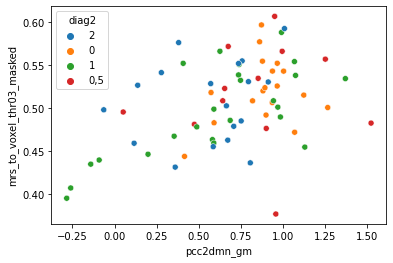

In [32]:
sns.scatterplot(x='pcc2dmn_gm', y='mrs_to_voxel_thr03_masked', hue='diag2', data=data)

In [51]:
stats.pearsonr(data.pcc2dmn_gm.values, data.mrs_to_voxel_thr03_masked.values)

(0.43280511227261814, 0.000146417447442382)

In [49]:
data.to_csv('/home/orco/Dokumente/Charitè/fmri/conn_covs_jun_SCD_mrs2vox_thr03masked.csv')

In [54]:
np.savez('./conns_thrs.npz', conns_thrs=conns_thrs)